# Research Question No. 5
This research question aims to investigate the characteristics of groups of bugs for which classifiers yield better accuracy.

# 1. Experimental parameters


| Parameter                  |         Value        |
|----------------------------|:--------------------:|
| Project                    |        Eclipse, Freedesktop, Gcc, Gnome, Mozilla, WineHQ       |
| Algorithms                 | NN |
| Metrics                    | Accuracy |
| Features                   | Long Description |
| Number of Terms            |        100       |
| Balancing                  |        Smote   |
| Resampling                 |        Repeated CV 5 x 2       |
| Threshold                  |        365       |








Every bug which its report have indicated that the number of days to resolve is less than or equal to **threshold fixed** was considered a **non-long lived bug** and that which the number of days to resolve is greater than this threshold was considered as a **long-live bug**. 

# 2. Setup environment

In [47]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [48]:
import os 
import matplotlib.pyplot  as plt 
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import seaborn as sns 
from wordcloud import WordCloud
from scipy.stats import friedmanchisquare
from scipy.stats import kruskal

# Setup Matplotlib
plt.rc('figure', figsize=(20, 20))
plt.style.use('default')
SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=SMALL_SIZE)  # fontsize of the figure title
%matplotlib inline 

# Setup Seaborn
sns.set_context("paper")
sns.set_style("ticks")

pd.set_option('display.max_columns', None)

results_gcc_path = "datasets/20190926143854_rq4e4_gcc_predict_long_lived_tests_balanced_acc.csv"
reports_gcc_path = "datasets/20190917_gcc_bug_report_data.csv"

results_eclipse_path = "datasets/20190926143854_rq4e4_eclipse_predict_long_lived_tests_balanced_acc.csv"
reports_eclipse_path = "datasets/20190917_eclipse_bug_report_data.csv"

print("Setup complete")

Setup complete


# 3. Load data

In [49]:
    !echo "\nHeader of metrics file $reports_gcc_path"
    !head -n 2 $reports_gcc_path

    !echo "\nNumber of lines in the file $reports_gcc_path"
    !wc -l $reports_gcc_path
    
    !echo "\nHeader of metrics file $results_eclipse_path"
    !head -n 2 $results_eclipse_path

    !echo "\nNumber of lines in the file $results_eclipse_path"
    !wc -l $results_eclipse_path


Header of metrics file datasets/20190917_gcc_bug_report_data.csv
bug_id,creation_date,component_name,product_name,short_description,long_description,assignee_name,reporter_name,resolution_category,resolution_code,status_category,status_code,update_date,quantity_of_votes,quantity_of_comments,resolution_date,bug_fix_time,severity_category,severity_code
CLASSPATH-26758,2006-03-19,awt,CLASSPATH,GdkFontPeer.getPostScriptFontName unimplemented,The Openstreetmap applet expects java.awt.Font.getPSFontName() to return something non-null.,unassigned,roman,fixed,1,resolved,4,2006-05-20,0,12,2006-05-20,62,normal,2

Number of lines in the file datasets/20190917_gcc_bug_report_data.csv
489575 datasets/20190917_gcc_bug_report_data.csv

Header of metrics file datasets/20190926143854_rq4e4_eclipse_predict_long_lived_tests_balanced_acc.csv
bug_id,bug_fix_time,long_lived,y_hat
4DIAC-489747,139,Y,N

Number of lines in the file datasets/20190926143854_rq4e4_eclipse_predict_long_lived_tests_balanced_acc.cs

In [50]:
# read data.
reports_gcc_data  = pd.read_csv(reports_gcc_path)
rows_and_cols = reports_gcc_data.shape
print(f"There are {rows_and_cols[0]} rows and {rows_and_cols[1]} columns in {reports_gcc_path}.\n")

results_gcc_data = pd.read_csv(results_gcc_path)
rows_and_cols = results_gcc_data.shape
print(f"There are {rows_and_cols[0]} rows and {rows_and_cols[1]} columns in {results_gcc_path}.\n")


reports_eclipse_data  = pd.read_csv(reports_eclipse_path)
rows_and_cols = reports_eclipse_data.shape
print(f"There are {rows_and_cols[0]} rows and {rows_and_cols[1]} columns in {reports_eclipse_path}.\n")

results_eclipse_data = pd.read_csv(results_eclipse_path)
rows_and_cols = results_eclipse_data.shape
print(f"There are {rows_and_cols[0]} rows and {rows_and_cols[1]} columns in {results_eclipse_path}.\n")


There are 10000 rows and 19 columns in datasets/20190917_gcc_bug_report_data.csv.

There are 2480 rows and 4 columns in datasets/20190926143854_rq4e4_gcc_predict_long_lived_tests_balanced_acc.csv.

There are 10000 rows and 19 columns in datasets/20190917_eclipse_bug_report_data.csv.

There are 2408 rows and 4 columns in datasets/20190926143854_rq4e4_eclipse_predict_long_lived_tests_balanced_acc.csv.



# 4. Test Results Analysis

### 4.1 Review data

In [51]:
results_gcc_data.head()

,bug_id,bug_fix_time,long_lived,y_hat
0,CLASSPATH-16983,15,N,N
1,CLASSPATH-17008,342,N,N
2,CLASSPATH-17060,337,N,N
3,CLASSPATH-18312,5,N,N
4,CLASSPATH-21635,96,N,N


In [52]:
reports_gcc_data['long_lived_observed']  = reports_gcc_data['bug_fix_time'].apply(lambda t: 'long-lived' if t > 365 else 'short-lived')

In [64]:
reports_gcc_data[['bug_fix_time', 'long_lived_observed']].head()

,bug_fix_time,long_lived_observed
0,62,short-lived
1,2,short-lived
2,1089,long-lived
3,11,short-lived
4,62,short-lived


In [60]:
results_eclipse_data.head()

,bug_id,bug_fix_time,long_lived,y_hat
0,4DIAC-489747,139,Y,N
1,4DIAC-495630,38,Y,Y
2,4DIAC-500078,38,Y,Y
3,4DIAC-511266,0,N,N
4,4DIAC-518907,200,Y,N


In [62]:
reports_eclipse_data['long_lived_observed']  = reports_eclipse_data['bug_fix_time'].apply(lambda t: 'long-lived' if t > 365 else 'short-lived')

In [59]:
reports_eclipse_data[['bug_fix_time', 'long_lived_observed']].head()

,bug_fix_time,long_lived_observed
0,0,short-lived
1,177,short-lived
2,1,short-lived
3,50,short-lived
4,264,short-lived


## 4.2 Results analysis

In [79]:
results_gcc_merged_data = pd.merge(
    reports_gcc_data,
    results_gcc_data[['bug_id', 'long_lived', 'y_hat']],
    left_on='bug_id',
    right_on='bug_id',
    how='inner'
)
long_lived_gcc_predicted_bugs.loc[results_gcc_merged_data.long_lived == 'Y', 'status_prediction'] = long_lived_gcc_predicted_bugs['y_hat'].apply(lambda t: 'True Positive' if t == 'Y' else 'False Negative')


In [81]:
long_lived_gcc_predicted_bugs.head()

,bug_id,creation_date,component_name,product_name,short_description,long_description,assignee_name,reporter_name,resolution_category,resolution_code,status_category,status_code,update_date,quantity_of_votes,quantity_of_comments,resolution_date,bug_fix_time,severity_category,severity_code,long_lived_observed,long_lived,y_hat,status_prediction
0,GCC-43804,2010-04-19,target,GCC,[4.6 regression] ICE in reload_cse_simplify_op...,$ gcc/xgcc -Bgcc/ -O2 -fpic -S memusage.i \nme...,rsandifo,schwab,fixed,1,resolved,4,2013-04-12,0,29,2013-04-12,1089,normal,2,long-lived,Y,N,False Negative
4,GCC-560,2000-09-21,target,GCC,[Solaris 8 x86] static code segfaults before main,If you compile static code any code with gcc o...,unassigned,rami.lehti,fixed,1,resolved,4,2003-07-25,0,2,2003-07-25,1037,normal,2,long-lived,Y,Y,True Positive
9,GCC-8340,2002-10-24,target,GCC,ICE on x86 inline asm w/ -fPIC,From: Glen Nakamura \nTo: gcc-gnats@gcc.gnu.or...,ebotcazou,glen,fixed,1,resolved,4,2014-10-13,0,10,2014-10-13,4372,normal,2,long-lived,Y,N,False Negative
11,GCC-65757,2015-04-13,libquadmath,GCC,gfortran gives incorrect result for anint with...,gfortran gives an incorrect result for the ani...,jvdelisle,bugs,fixed,1,resolved,4,2019-03-01,0,26,2017-09-16,887,normal,2,long-lived,Y,N,False Negative
12,GCC-2434,2001-03-30,target,GCC,Compilation with large file support (solaris &...,When compiling C++ programs using the flags fo...,unassigned,pnobili,fixed,1,resolved,4,2003-07-25,0,5,2003-07-25,847,normal,2,long-lived,Y,Y,True Positive


In [80]:

results_eclipse_merged_data = pd.merge(
    reports_eclipse_data,
    results_eclipse_data[['bug_id', 'long_lived', 'y_hat']],
    left_on='bug_id',
    right_on='bug_id',
    how='inner'
)
long_lived_eclipse_predicted_bugs.loc[results_eclipse_merged_data.long_lived == 'Y', 'status_prediction']  = long_lived_eclipse_predicted_bugs['y_hat'].apply(lambda t: 'True Positive' if t == 'Y' else 'False Negative')

In [82]:
long_lived_eclipse_predicted_bugs.head()

,bug_id,creation_date,component_name,product_name,short_description,long_description,assignee_name,reporter_name,resolution_category,resolution_code,status_category,status_code,update_date,quantity_of_votes,quantity_of_comments,resolution_date,bug_fix_time,severity_category,severity_code,long_lived_computed,long_lived,y_hat,status_prediction
0,EQUINOX-259283,2008-12-18,p2,EQUINOX,[engine] Need a data area for actions,Currently we're persisting some data in the pr...,simon_kaegi,simon_kaegi,fixed,1,resolved,4,2009-01-21,0,2,2009-01-21,34,normal,2,short-lived,Y,Y,True Positive
1,Z_ARCHIVED-58853,2004-04-16,Hyades,Z_ARCHIVED,Imported Log Correlatior sample project has pr...,Found in Hyades 3.0 20040416_1005 driver.\n\nS...,apnan,shiah,fixed,1,closed,6,2012-02-15,0,6,2004-04-22,6,normal,2,short-lived,Y,Y,True Positive
2,PLATFORM-4902,2001-10-11,Team,PLATFORM,Project out of sync after release (1GKS577),Sometimes after a release the project stays ou...,valentam,valentam,fixed,1,resolved,4,2002-03-21,0,3,2002-03-21,161,normal,2,short-lived,Y,Y,True Positive
3,BIRT-83104,2005-01-18,Report,BIRT,Patch to add files to cvsignore,Attached patch adds the bin directory and lib/...,Birt-Data-inbox,thierry.lach,fixed,1,resolved,4,2005-12-21,0,5,2005-01-25,7,trivial,1,short-lived,Y,Y,True Positive
4,VIRGO-337233,2011-02-15,runtime,VIRGO,Browsing the OSGi state in the Admin Console b...,To Reproduce:\n\n1. In the OSGi state tab sele...,virgo-inbox,eclipse,fixed,1,closed,6,2011-05-09,0,4,2011-05-09,83,major,4,short-lived,Y,Y,True Positive


In [179]:
def plot_bar (project, data, column, n):
    
    top_n = data.groupby(column)[column].agg(['count'])
    top_n = top_n.sort_values('count', ascending=False).head(n)
    top_n = data.loc[data[column].isin(top_n.index)].groupby(column)['status_prediction'].value_counts(normalize=True).unstack()
    
    fig, ax = plt.subplots(figsize=(10, 10))
    top_n.plot(kind='barh', stacked='True',  color=["tab:red", "tab:blue"], ax=ax)
    
    ax.set(xlim=(0, 1))
    ax.set_xlabel('percentage', fontsize=MEDIUM_SIZE)
    ax.set_ylabel(column, fontsize=MEDIUM_SIZE)
    ax.set_title(project, fontsize=BIGGER_SIZE)
    
    plt.legend()
    plt.xticks(fontsize=MEDIUM_SIZE)
    plt.yticks(fontsize=MEDIUM_SIZE)

### Reporter Name

### GCC

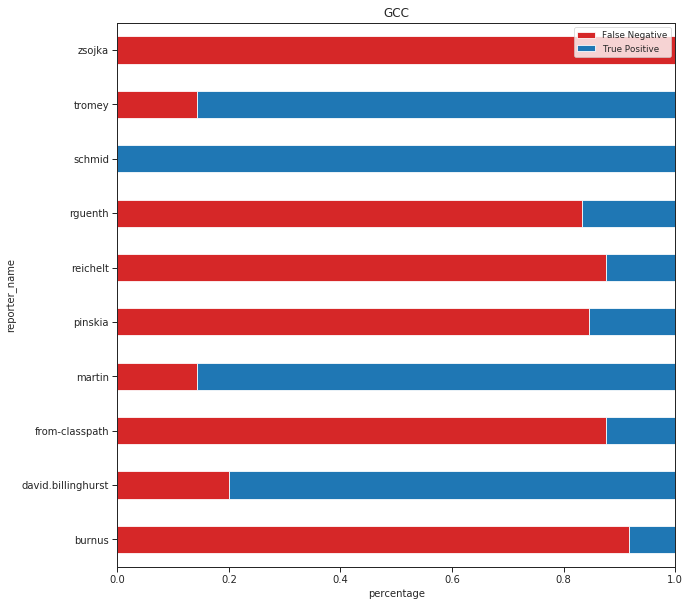

In [180]:
plot_bar('GCC', long_lived_gcc_predicted_bugs, 'reporter_name',10)

### Eclipse

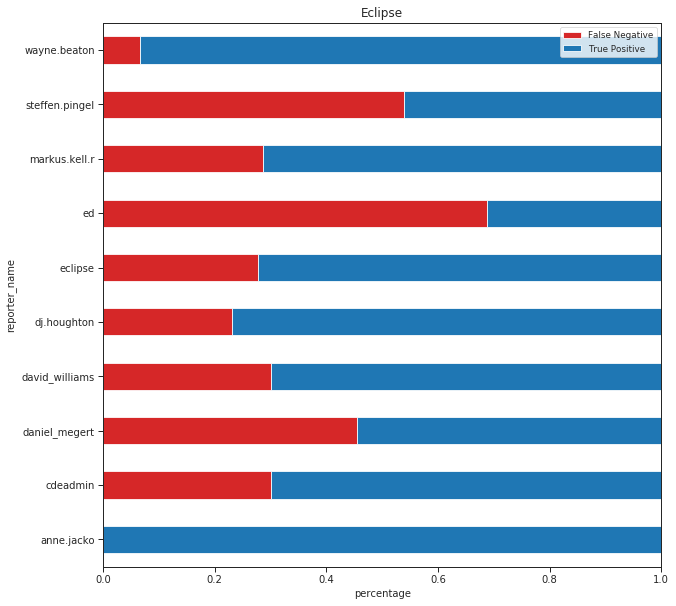

In [181]:
plot_bar('Eclipse', long_lived_eclipse_predicted_bugs, 'reporter_name',10)

### Assignee

### GCC

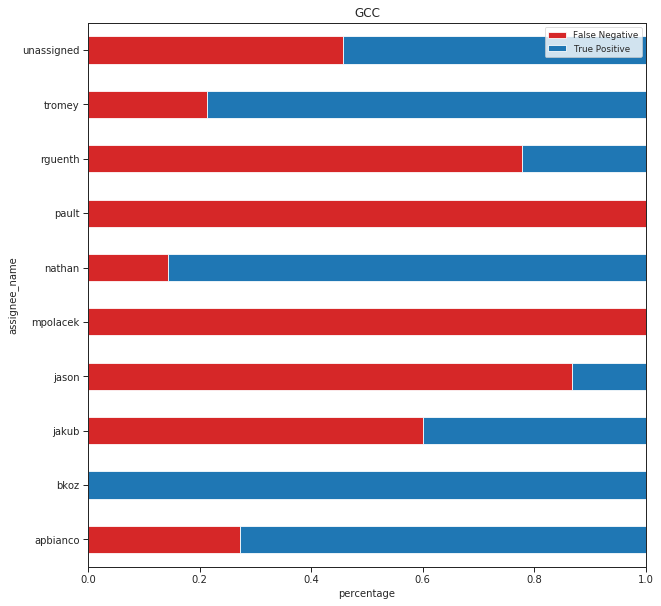

In [182]:
plot_bar('GCC', long_lived_gcc_predicted_bugs, 'assignee_name',10)

### Eclipse

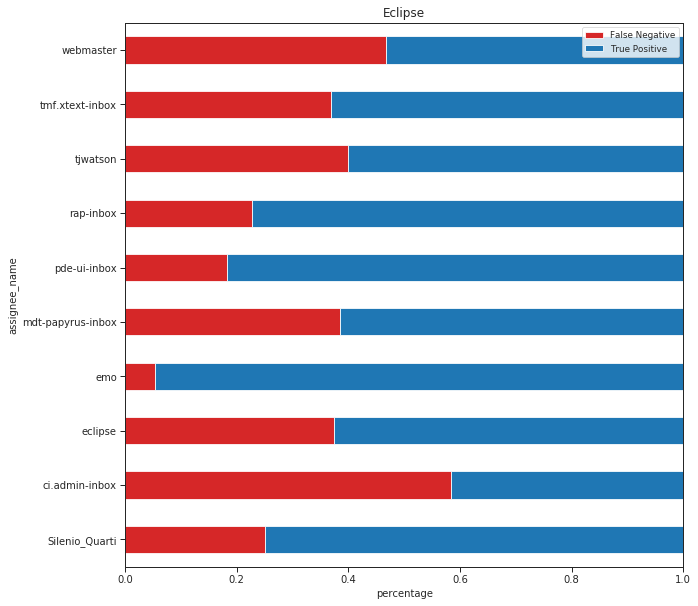

In [183]:
plot_bar('Eclipse', long_lived_eclipse_predicted_bugs, 'assignee_name',10)

### Component Name

### GCC

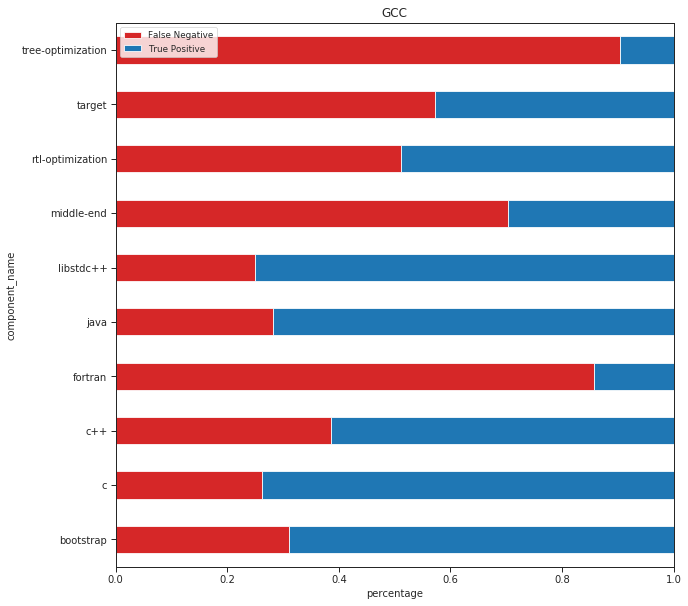

In [184]:
plot_bar('GCC', long_lived_gcc_predicted_bugs, 'component_name',10)

### Eclipse

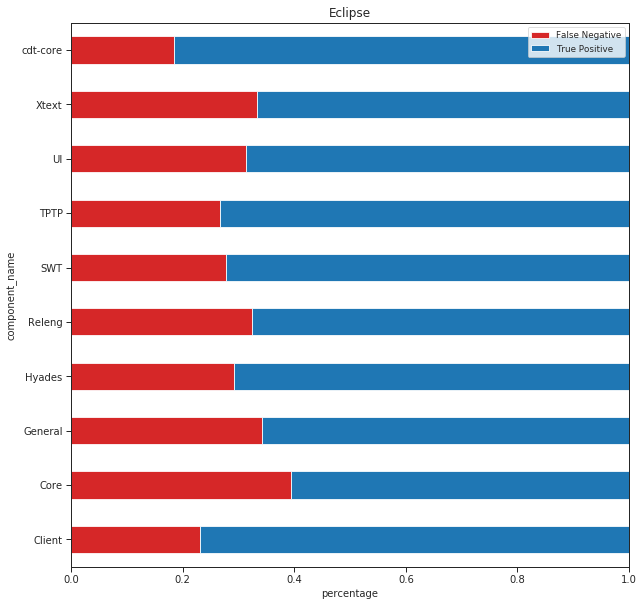

In [185]:
plot_bar('Eclipse', long_lived_eclipse_predicted_bugs, 'component_name',10)

### Severity Level

### GCC

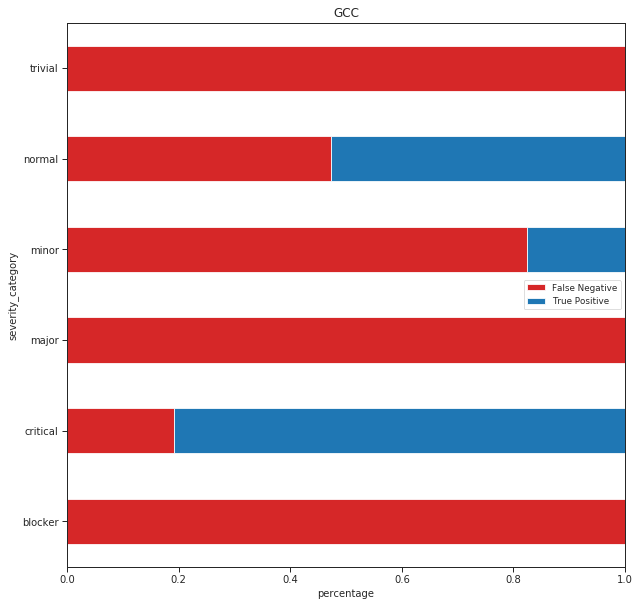

In [186]:
plot_bar('GCC', long_lived_gcc_predicted_bugs, 'severity_category',10)


### Eclipse

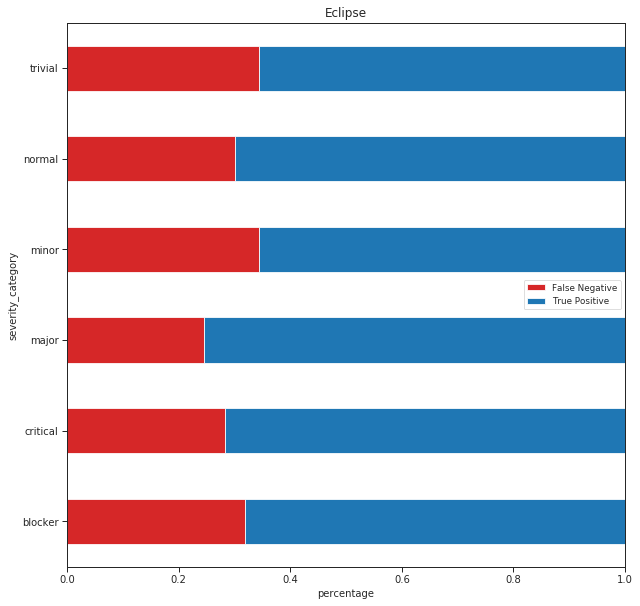

In [187]:
plot_bar('Eclipse', long_lived_eclipse_predicted_bugs, 'severity_category',10)

### Description 
Existem muitas palavras relacionadas com código(stop words).

In [31]:
word_frequency_gcc_path     = "datasets/20191028080345_gcc_word_frequency.csv"
word_frequency_eclipse_path = "datasets/20191028080345_eclipse_word_frequency.csv"
word_frequency_gcc_data     = pd.read_csv(word_frequency_gcc_path) 
word_frequency_eclipse_data = pd.read_csv(word_frequency_eclipse_path)

word_frequency_gcc_data['freq'] = word_frequency_gcc_data['freq'].astype(int)
word_frequency_eclipse_data['freq'] = word_frequency_eclipse_data['freq'].astype(int)


### GCC

In [32]:
word_frequency_gcc_data.head()

,word,freq,status,project
0,lib,6,Corrected,gcc
1,includ,6,Corrected,gcc
2,linux,6,Corrected,gcc
3,usr,6,Corrected,gcc
4,int,6,Corrected,gcc


In [33]:
from PIL import Image
import matplotlib
def transform_format(val):
    if val == 0:
        return 255
    else:
        return val
    
def plot_word_cloud(data, status):
    data = data[data['status']==status]
    cloud_mask = np.array(Image.open("cloud.png"))
    
    #transformed_cloud_mask = np.ndarray((cloud_mask.shape[0], cloud_mask.shape[1]), np.int32)

    #for i in range(len(cloud_mask)):
    #    transformed_cloud_mask[i] = list(map(transform_format, cloud_mask[i]))
    
    word_frequency = {x[0]: x[1] for x in data.itertuples(index=False)}
    wordcloud = WordCloud(width=900
                      , height=500
                      , mask=cloud_mask
                      , background_color='white'
                      , max_words=100
                      , colormap=matplotlib.cm.inferno
                      , relative_scaling=1
                      , normalize_plurals=False).generate_from_frequencies(word_frequency)
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    #plt.title(f"Long-lived {status} Predicted", fontsize=20)
    plt.axis("off")


#### Histograms 

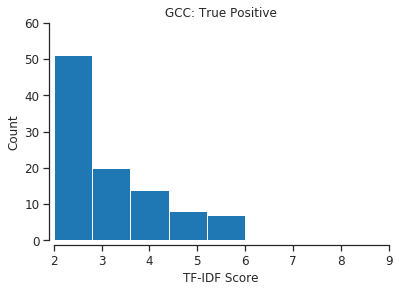

In [34]:
freqs=word_frequency_gcc_data[word_frequency_gcc_data['status']=='Corrected']['freq']

plt.hist(freqs, color='tab:blue', bins=5)
sns.despine(offset=5)

plt.title("GCC: True Positive")
plt.xticks([2, 3, 4, 5, 6, 7, 8, 9], fontsize=SMALL_SIZE)
plt.xlim(2, 9)
plt.xlabel('TF-IDF Score', fontsize=SMALL_SIZE)
plt.yticks([0, 10, 20, 30, 40, 50, 60], fontsize=SMALL_SIZE)
plt.ylim(0, 60)
plt.ylabel('Count', fontsize=SMALL_SIZE)

plt.savefig('figures/rq5-gcc-tf-idf-corrected-predicted.pdf', format="pdf", dpi=600, bbox_inches='tight')

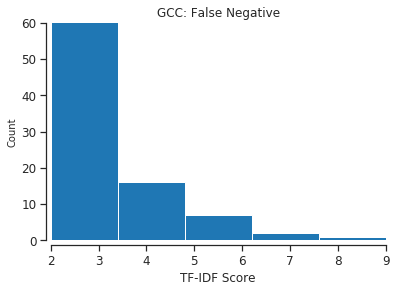

In [35]:
plt.hist(word_frequency_gcc_data[word_frequency_gcc_data['status']=='Incorrected']['freq']
         , bins=5
         , color='tab:blue')
sns.despine(offset=5)
plt.title("GCC: False Negative")
plt.xticks([2, 3, 4, 5, 6, 7, 8, 9], fontsize=SMALL_SIZE)
plt.xlim(2, 9)
plt.xlabel('TF-IDF Score', fontsize=SMALL_SIZE)
plt.yticks([0, 10, 20, 30, 40, 50, 60], fontsize=SMALL_SIZE)
plt.ylim(0, 60)
plt.ylabel('Count', fontsize=10)
plt.savefig('figures/rq5-gcc-tf-idf-uncorrected-predicted.pdf', format="pdf", dpi=600, bbox_inches='tight')

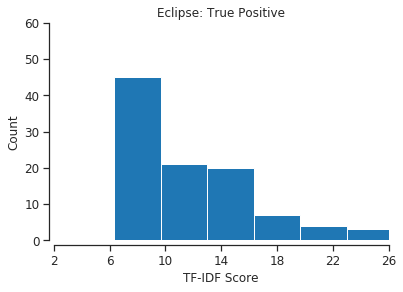

In [36]:
plt.hist(word_frequency_eclipse_data[word_frequency_eclipse_data['status']=='Corrected']['freq'].astype('int')
         , align='left'
         , bins=6
         , color='tab:blue')
sns.despine(offset=5)
plt.title("Eclipse: True Positive")
plt.xticks([2, 6, 10, 14, 18, 22, 26], fontsize=SMALL_SIZE)
plt.xlim(2, 26)
plt.xlabel('TF-IDF Score', fontsize=SMALL_SIZE)
plt.yticks([0, 10, 20, 30, 40, 50, 60], fontsize=SMALL_SIZE)
plt.ylim(0, 60)
plt.ylabel('Count', fontsize=SMALL_SIZE)
plt.savefig('figures/rq5-eclipse-tf-idf-corrected-predicted.pdf', format="pdf", dpi=600, bbox_inches='tight')

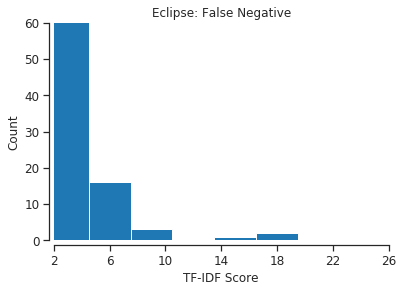

In [37]:
plt.hist(word_frequency_eclipse_data[word_frequency_eclipse_data['status']=='Incorrected']['freq']
         , align='left'
         , bins=6
         , color='tab:blue')
sns.despine(offset=5)
plt.title("Eclipse: False Negative")
plt.xticks([2, 6, 10, 14, 18, 22, 26], fontsize=SMALL_SIZE)
plt.xlim(2, 26)
plt.xlabel('TF-IDF Score', fontsize=SMALL_SIZE)
plt.yticks([0, 10, 20, 30, 40, 50, 60], fontsize=SMALL_SIZE)
plt.ylim(0, 60)
plt.ylabel('Count', fontsize=SMALL_SIZE)
plt.savefig('figures/rq5-eclipse-tf-idf-uncorrected-predicted.pdf', format="pdf", dpi=600, bbox_inches='tight')

In [38]:
a = list(word_frequency_gcc_data[word_frequency_gcc_data.status=="Corrected"]['word'])
b = list(word_frequency_gcc_data[word_frequency_gcc_data.status=="Incorrected"]['word'])

In [39]:
len(set(a) | set(b))

143

In [40]:
a = list(word_frequency_eclipse_data[word_frequency_eclipse_data.status=="Corrected"]['word'])
b = list(word_frequency_eclipse_data[word_frequency_eclipse_data.status=="Incorrected"]['word'])

In [41]:
len(set(a) | set(b))

149